## Aufgabenblatt 4

#### Imports

In [24]:
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

### Load Data

In [25]:
df = pd.read_csv('data/jena_climate_2009_2016.csv')
df.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


##### Konvertiere 'Date Time' zu einem Datum und setze dieses Datum als Index, zudem ändere den Namen auf 'date' weil ich auf den Mittelwert pro Tag ändere und somit die Zeit unwichtig ist

In [26]:
df['date'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('date', inplace=True)

##### Extrahiere Temperatur (in °C und nicht K) und Luftfeuchtigkeit

In [27]:
df['date'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('date', inplace=True)

In [28]:
temperatur = df['T (degC)']
luftfeuchtigkeit = df['rh (%)']
temperatur.head(3), luftfeuchtigkeit.head(3)

(date
 2009-01-01 00:10:00   -8.02
 2009-01-01 00:20:00   -8.41
 2009-01-01 00:30:00   -8.51
 Name: T (degC), dtype: float64,
 date
 2009-01-01 00:10:00    93.3
 2009-01-01 00:20:00    93.4
 2009-01-01 00:30:00    93.9
 Name: rh (%), dtype: float64)

##### Summiere auf einen Tag und interpoliere fehlende Werte

In [29]:
# Es wird auch die Spalten umbenannt
# Und dann zu einem Dataframe zusammengefügt
temperatur = temperatur.resample('D').mean().interpolate().rename('temperature').to_frame()
luftfeuchtigkeit = luftfeuchtigkeit.resample('D').mean().interpolate().rename('humidity').to_frame()

### Aufgabe 1 - ETS

In [30]:
# Saisonale Dekomposition der Temperatur
decomposition_temperature = sm.tsa.seasonal_decompose(temperatur, model='additive', period = 365)

# Saisonale Dekomposition der Luftfeuchtigkeit
decomposition_humidity = sm.tsa.seasonal_decompose(luftfeuchtigkeit, model='additive', period = 365)

## Plotten der Lösungen

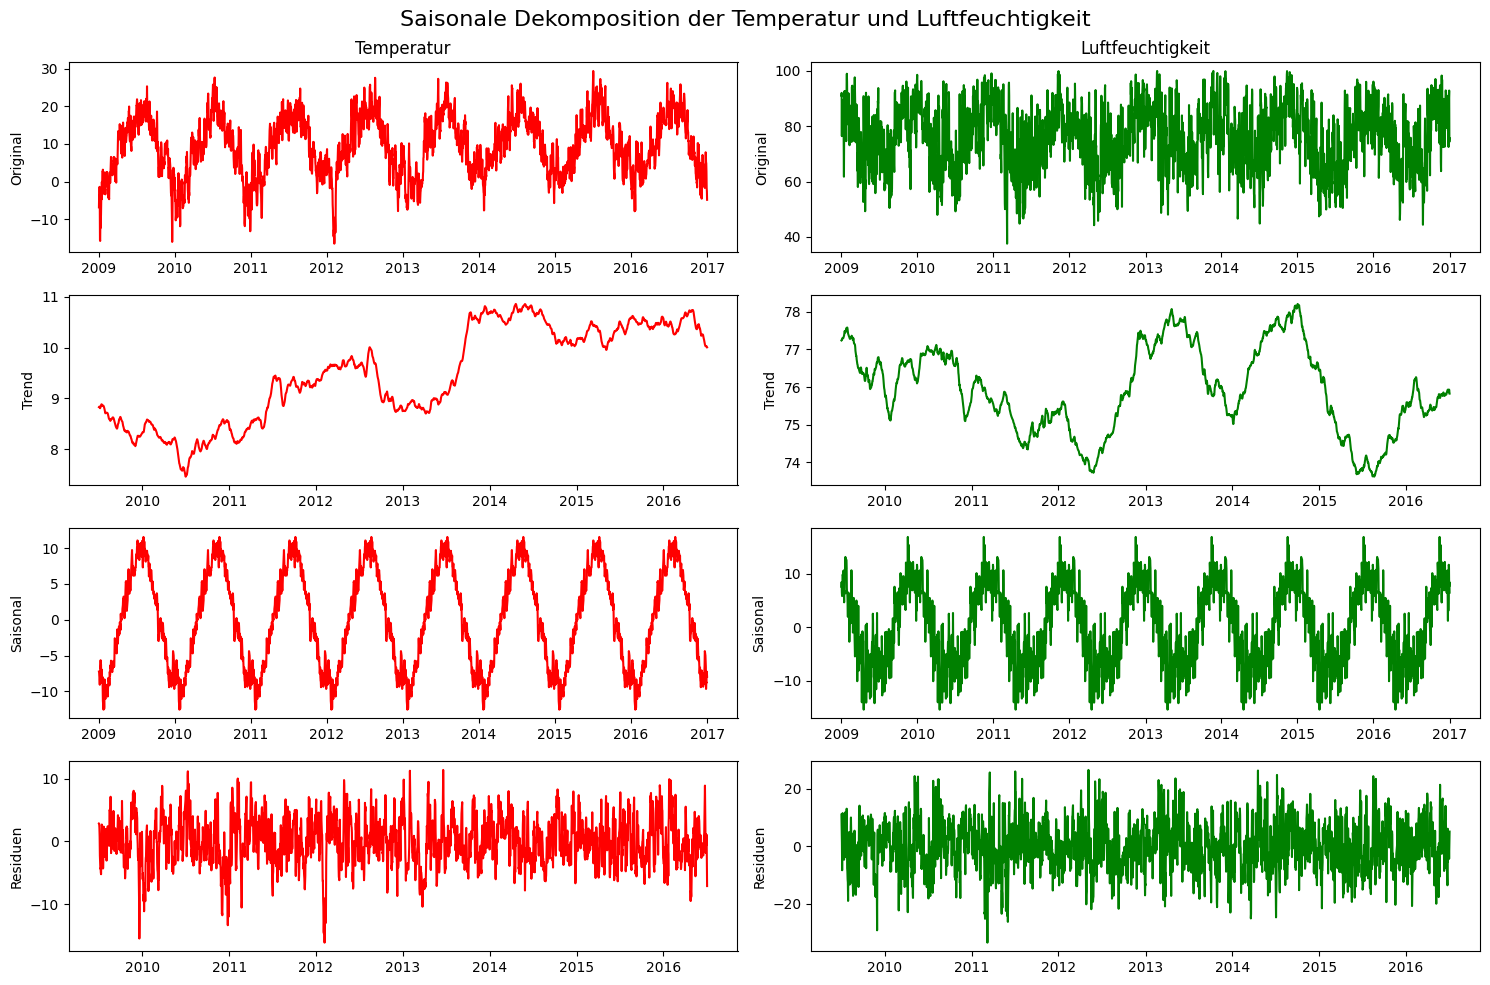

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
fig.suptitle('Saisonale Dekomposition der Temperatur und Luftfeuchtigkeit', fontsize=16)
axes[0, 0].plot(temperatur, label='Original', color='red')
axes[0, 0].set_title('Temperatur')
axes[0, 0].set_ylabel('Original')
axes[1, 0].plot(decomposition_temperature.trend, color='red')
axes[1, 0].set_ylabel('Trend')
axes[2, 0].plot(decomposition_temperature.seasonal, color='red')
axes[2, 0].set_ylabel('Saisonal')
axes[3, 0].plot(decomposition_temperature.resid, color='red')
axes[3, 0].set_ylabel('Residuen')

axes[0, 1].plot(luftfeuchtigkeit, color='green')
axes[0, 1].set_title('Luftfeuchtigkeit')
axes[0, 1].set_ylabel('Original')
axes[1, 1].plot(decomposition_humidity.trend, color='green')
axes[1, 1].set_ylabel('Trend')
axes[2, 1].plot(decomposition_humidity.seasonal, color='green')
axes[2, 1].set_ylabel('Saisonal')
axes[3, 1].plot(decomposition_humidity.resid, color='green')
axes[3, 1].set_ylabel('Residuen')

fig.tight_layout()
plt.show()


### Aufgabe 2 - EWMA & Holt-Winters

In [32]:
temperatur['temperature_EWMA'] = temperatur['temperature'].ewm(span=365,adjust=False).mean()
temperatur['temperature_HW'] = sm.tsa.ExponentialSmoothing(temperatur['temperature'], 
                                                           trend='add', 
                                                           seasonal='add',
                                                           seasonal_periods=365).fit().fittedvalues

luftfeuchtigkeit['humidity_EWMA'] = luftfeuchtigkeit['humidity'].ewm(span=365,adjust=False).mean()
luftfeuchtigkeit['humidity_HW'] = sm.tsa.ExponentialSmoothing(luftfeuchtigkeit['humidity'],
                                                              trend='add',
                                                              seasonal='add',
                                                              seasonal_periods=365).fit().fittedvalues

/home/schneialexan@edu.local/miniconda3/envs/dpl-ha4/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



##### Plotten der Lösungen

In [33]:
fig = px.line(temperatur, x=temperatur.index, y=['temperature', 'temperature_EWMA', 'temperature_HW'])
# change linesize of only the temperature to 3
fig.update_traces(line=dict(width=3), selector=dict(name='temperature'))
fig.update_layout(title='Temperatur: Original, EWMA und Holt-Winters', xaxis_title='Datum', yaxis_title='Temperatur')
fig.show()

In [34]:
fig = px.line(luftfeuchtigkeit, x=luftfeuchtigkeit.index, y=['humidity', 'humidity_EWMA', 'humidity_HW'])
# change linesize of only the humidity to 3
fig.update_traces(line=dict(width=3), selector=dict(name='humidity'))
fig.update_layout(title='Luftfeuchtigkeit: Original, EWMA und Holt-Winters', xaxis_title='Datum', yaxis_title='Luftfeuchtigkeit')
fig.show()

##### Metrik

In [37]:
mae_temperature_EWMA = mean_absolute_error(temperatur['temperature'], temperatur['temperature_EWMA'])
mae_temperature_HW = mean_absolute_error(temperatur['temperature'], temperatur['temperature_HW'])

mae_humidity_EWMA = mean_absolute_error(luftfeuchtigkeit['humidity'], luftfeuchtigkeit['humidity_EWMA'])
mae_humidity_HW = mean_absolute_error(luftfeuchtigkeit['humidity'], luftfeuchtigkeit['humidity_HW'])

print('MAE für die Temperatur mit EWMA: ', mae_temperature_EWMA)
print('MAE für die Temperatur mit Holt-Winters: ', mae_temperature_HW)
print('MAE für die Luftfeuchtigkeit mit EWMA: ', mae_humidity_EWMA)
print('MAE für die Luftfeuchtigkeit mit Holt-Winters: ', mae_humidity_HW)

MAE für die Temperatur mit EWMA:  6.563841775035478
MAE für die Temperatur mit Holt-Winters:  1.765230472921248
MAE für die Luftfeuchtigkeit mit EWMA:  9.308978155079274
MAE für die Luftfeuchtigkeit mit Holt-Winters:  6.032137636752686


### Aufgabe 3 - Autokorrelation

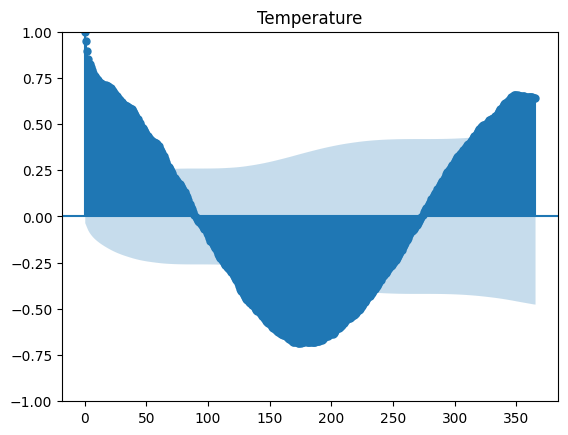

In [39]:
sm.graphics.tsa.plot_acf(temperatur['temperature'], title="Temperature", lags=365);

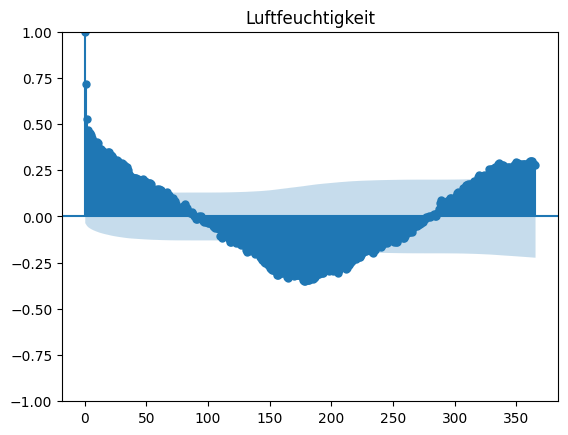

In [42]:
sm.graphics.tsa.plot_acf(luftfeuchtigkeit['humidity'], title="Luftfeuchtigkeit", lags=365);